# Thick film dispersion and perturbation analysis

- the dispersion of a 50 nm thick Permalloy film is computed in the Damon-Eshbach geometry
- the Kalinikos-Slavin equation [B. A. Kalinikos and A. N. Slavin, “Theory of dipole-exchange spin wavespectrum for ferromagnetic films with mixed exchange boundary condi-tions,”Journal of Physics C: Solid State Physics19, 7013–7033 (1986)] is also supplied as a function
- numerical and analytical are directly compared and shows that the zeroth-order perturbation theory isn't giving the proper dispersion for thick films
- an example for the numerical perturbation calculation is also shown, and as expected the resulting dispersion is in quantitatice agreement with the theory of Kalinikos and Slavin


In [1]:
import tetrax as tx
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt

### Analytics: Kalinikos - Slavin equation
- the function omega computes the dispersion for both backward volume (BVM) and Daemon-Eshbach (SW) geometry by giving the proper keyword as an input to the function at call

In [2]:
def omega(k, gamma, M_s, A, T, B_0=0, kind="BVW", n=0, mu_0=4*np.pi*1e-7):

    omega_M = gamma * mu_0 * M_s
    omega_0 = gamma * B_0
    Lambda = np.sqrt(2*A / (mu_0 *M_s**2))


    k_n = np.sqrt(k**2 + (n*np.pi/T)**2)

    rat = k**2 / k_n**2
    kron_n = (n == 0)
    P_nn = rat*(1 - (2/(1+kron_n))*rat*(1-(-1)**n *np.exp(-k*T))/(k*T))
    if kind == "BVW":
        return np.sqrt(
            (omega_0 + omega_M* Lambda**2 * k_n**2) *\
                (omega_0 + omega_M* Lambda**2 *k_n**2 + omega_M*(1-P_nn))
        )
    if kind == "SW":
        return np.sqrt(
            (omega_0 + omega_M * Lambda**2 *k_n**2 + omega_M*P_nn) *\
                (omega_0 + omega_M* Lambda**2 *k_n**2 + omega_M*(1-P_nn))
        )
    else:
        print("No valid spin wave kind specified in dispersion. "
              "Please use BVW or SW.")
        return k*0

### Numerical dispersion calculation

- we create a film with 50 nm thickness and a line trace mesh along the thickness with 1 nm resolution
- NOTE: the thickness direction is the y direction, propagation direction is the z direction.

In [3]:
T = 50
sample = tx.create_sample(geometry="layer")
msh = tx.geometries.monolayer_line_trace(50,1)
sample.set_geom(msh)

Setting geometry and calculating discretized differential operators on mesh.
Done.


- The film is magnetized along the x direction, using an external magnetic field of 20 mT, thus the wave vector is perpendicular to the equilibrium magnetization.

In [4]:
Msat = 796000. # A/m
Aex = 13e-12 # J/m
sample.Msat = Msat
sample.Aex = Aex
Bext = 20e-3
sample.mag = [1,0,0]
exp = tx.create_experimental_setup(sample,name="DE-geometry")
exp.Bext = [Bext,0,0]

In [5]:
dispersion = exp.eigenmodes(kmin=0,kmax=40e6,Nk=81,num_modes=3,num_cpus=-1)

100%|█████████████████████████████████████████████| 81/81 [00:13<00:00,  6.04it/s]


### Plotting of the dispersions from numerics and analytics

<IPython.core.display.Javascript object>


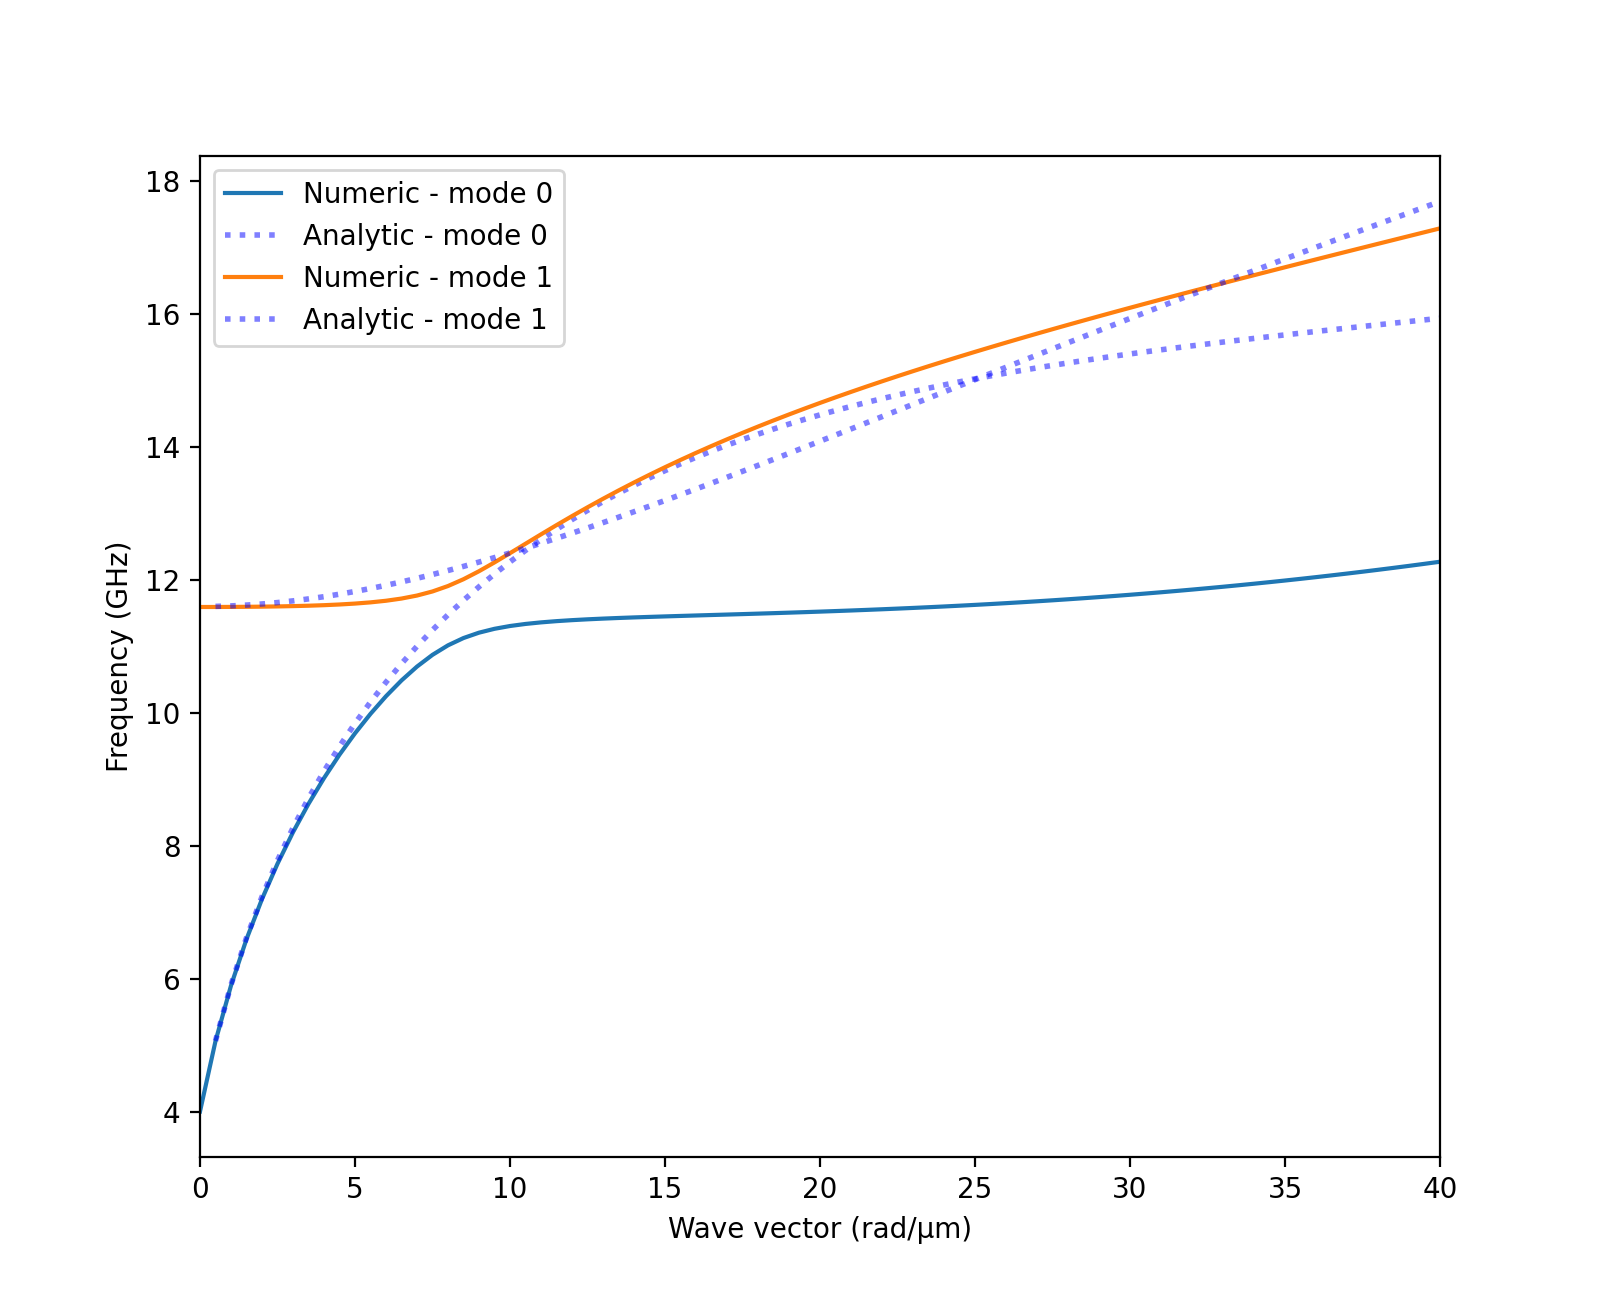

In [6]:
k_ = dispersion["k (rad/m)"]

plt.rcParams["figure.figsize"] = (8,6.5)
plt.figure()
for i in range(2):
    plt.plot(k_*1e-6,dispersion[f"f{i} (GHz)"],ls="-",label=f'Numeric - mode {i}')
    plt.plot(k_*1e-6,omega(np.abs(k_), sample.gamma, Msat, Aex, T*1e-9, Bext, kind="SW", n=i, mu_0=4*np.pi*1e-7)/(2*np.pi*1e9),ls=":",lw=2,alpha=0.5,c="b",label=f"Analytic - mode {i}")
    
plt.xlim([0,40])
plt.xlabel("Wave vector (rad/µm)")
plt.ylabel("Frequency (GHz)")
plt.legend()
plt.show()

### Perturbed dispersion calculation using numerics

- the same eigenmodes calculation function can be used with two further options eigenmodes(....,no_dip=True,perturbed_dispersion=True)
- this will result in computing the modes using all interactions except the dipol-dipole interaction and the dispersion will be computed using the obtained modes but with all interaction operators, this time including the dipole-dipole (for details check the User Guide)

In [7]:
dispersion_pert = exp.eigenmodes(kmin=0,kmax=40e6,Nk=81,num_modes=3,num_cpus=-1,no_dip=True,perturbed_dispersion=True)

100%|█████████████████████████████████████████████| 81/81 [00:00<00:00, 94.81it/s]


<IPython.core.display.Javascript object>


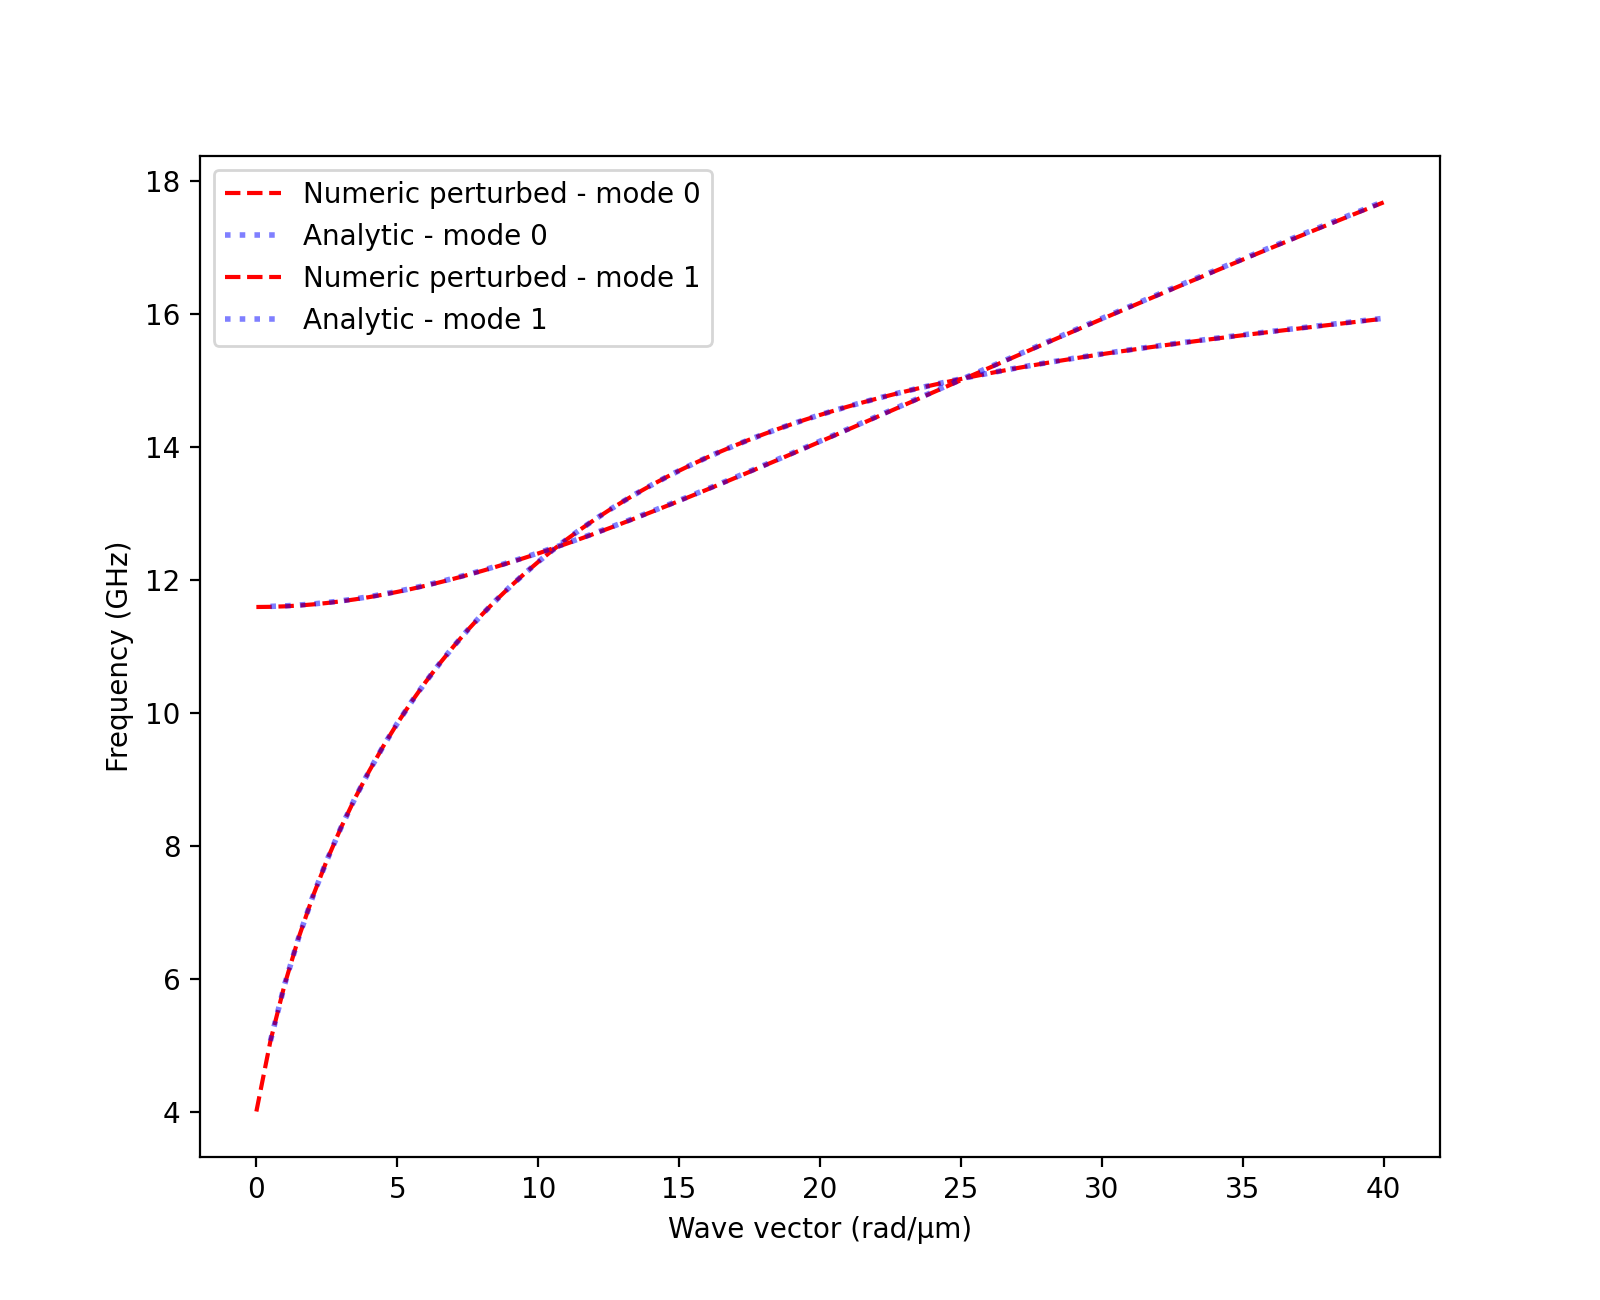

In [9]:
k_ = dispersion["k (rad/m)"]

plt.rcParams["figure.figsize"] = (8,6.5)
plt.figure()
for i in range(2):
#    plt.plot(k_*1e-6,dispersion[f"f{i} (GHz)"],ls="-",label=f'Numerics - mode {i}')
    plt.plot(k_*1e-6,dispersion_pert[f"f_pert_{i} (GHz)"],ls="--",alpha=1,c="r",label=f"Numeric perturbed - mode {i}")
    plt.plot(k_*1e-6,omega(np.abs(k_), sample.gamma, Msat, Aex, T*1e-9, Bext, kind="SW", n=i, mu_0=4*np.pi*1e-7)/(2*np.pi*1e9),ls=":",lw=2,alpha=0.5,c="b",label=f'Analytic - mode {i}')

plt.xlabel("Wave vector (rad/µm)")
plt.ylabel("Frequency (GHz)")
plt.legend()
plt.show()